In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
import PIL
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
import torchvision
import cv2
import math
%matplotlib inline

In [2]:
# Constants
DATA = 'RestrictedImageNet' # Choices: ['RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
SR_FACTOR_RIN = 8

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1

In [3]:
# Load dataset
dataset_function = getattr(datasets, 'CIFAR')
dataset = dataset_function('datasets/')
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [4]:

dataset_function = getattr(datasets, 'RestrictedImageNet')
dataset = dataset_function('datasets/')

# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): SequentialWithArgs(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [5]:
def downsample(x, step=None):
    down = ch.zeros([len(x), 3, 224//step, 224//step])

    for i in range(0, 224, step):
        for j in range(0, 224, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=None):
    up = ch.zeros([len(x), 3, 224, 224])
    for i in range(0, 224, step):
        for j in range(0, 224, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

In [6]:
# Get a batch of CIFAR images with classes in RestrictedImageNet

img_cifar, targ_cifar = [], []
cifar_to_in_dict = {
    2: 4, 3: 1, 5: 0, 6: 2
}

for _, (im, targ) in enumerate(test_loader):        
    for i in range(len(targ)):
        if len(img_cifar) >= BATCH_SIZE: 
            break
        elif targ[i].item() in cifar_to_in_dict.keys():
            img_cifar.append(im[i])
            targ_cifar.append(ch.tensor(cifar_to_in_dict[targ[i].item()], dtype=targ.dtype))
img_cifar, targ_cifar = ch.stack(img_cifar), ch.stack(targ_cifar)

torch.Size([10, 3, 32, 32])
torch.Size([10])


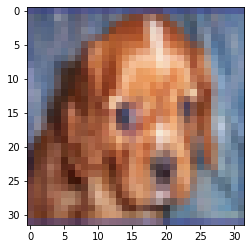

In [7]:
print(img_cifar.shape)
print(targ_cifar.shape)

plt.imshow(img_cifar[0,:,:,:].permute(1, 2, 0))

In [8]:
# PGD Parameters
kwargs = {
        'constraint':'2',
        'eps': 15,
        'step_size': 1,
        'iterations': 50,
        'do_tqdm':True,
        'targeted': True,
        'should_normalize': True
}

In [9]:
# Superresolution using PGD
img_cifar_up = upsample(img_cifar, step=7)
_, img_cifar_sr = model(img_cifar_up, targ_cifar, fake_relu=False, make_adv=True, **kwargs)

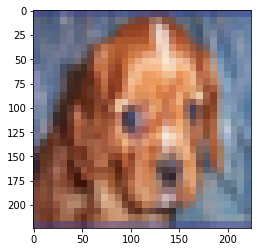

torch.Size([10, 3, 224, 224])


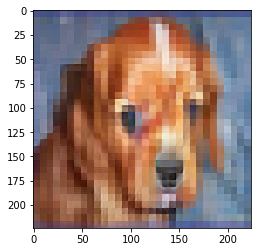

torch.Size([50, 3, 224, 224])
torch.Size([50])
tensor([6, 0, 3, 6, 4, 4, 6, 3, 4, 6, 4, 0, 6, 0, 3, 6, 0, 2, 3, 2, 6, 0, 2, 3,
        3, 4, 0, 3, 6, 4, 4, 3, 2, 4, 6, 6, 0, 3, 2, 2, 4, 0, 2, 2, 0, 2, 3, 0,
        4, 2])


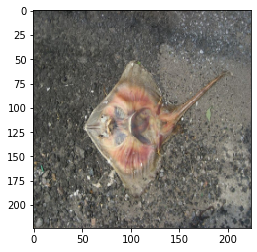

In [12]:
def load_dataset():
    data_path = '/tmp/InputImages/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = ch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=True
    )
    return train_loader

data_loader = load_dataset()
for i_batch, sample_batched in enumerate(data_loader):
    data = sample_batched[0]
    targets = sample_batched[1]
    print(data.shape)
    print(targets.shape)
    
    for i in range(len(targets)):
        if targets[i] == 1:
            targets[i] = 2
        elif targets[i] == 2:
            targets[i] = 3
        elif targets[i] == 3:
            targets[i] = 4
        elif targets[i] == 4:
            targets[i] = 6
    
    plt.imshow(data[0,:,:,:].permute(1,2,0))
    print(targets)

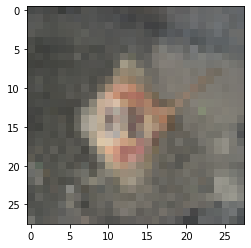

In [13]:
imgnt_ds = downsample(data, step=8)
imgnt_us = upsample(imgnt_ds, step=8)
plt.imshow(imgnt_ds[0,:,:,:].permute(1,2,0))


In [14]:
# PGD Parameters
kwargs = {
        'constraint':'2',
        'eps': 8,
        'step_size': 1,
        'iterations': 40,
        'do_tqdm':True,
        'targeted': True,
        'should_normalize': True
}

# Superresolution using PGD
_, imgnt_rec = model(imgnt_us, targets, fake_relu=True, make_adv=True, **kwargs)

torch.Size([50, 3, 224, 224])


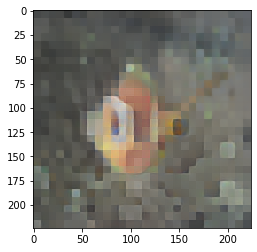

In [15]:
plt.imshow(imgnt_rec.detach().cpu()[0,:,:,:].permute(1,2,0))
print(imgnt_rec.shape)

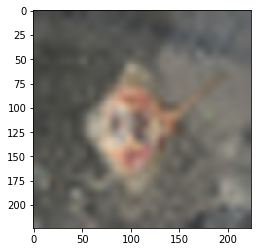

In [16]:
# Bicubic upsampling baseline
img_stack = imgnt_ds.numpy()
stack_ds = np.zeros([50,3,224,224])
for i in range(len(img_stack)):
    for j in range(len(img_stack[i])):
        stack_ds[i][j] = cv2.resize(img_stack[i][j],(224,224),interpolation=cv2.INTER_CUBIC)
plt.imshow(stack_ds[0,:,:,:].transpose(1,2,0))

In [21]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    qq = img1-img2
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
pic_num = 27

d=psnr(data.numpy(),stack_ds)
print(d)
d1=psnr(data.numpy(),imgnt_rec.detach().cpu().numpy())
print(d1)


22.096105316068385
20.912574349121442


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


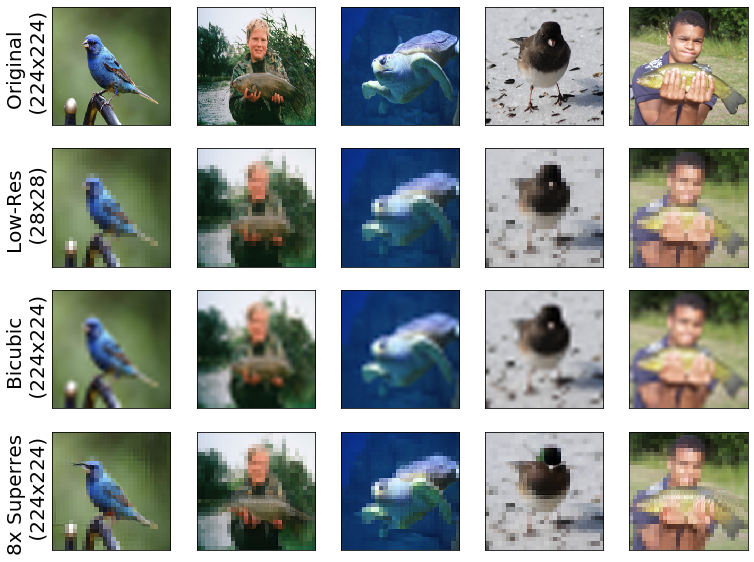

In [18]:
# Visualize superres results
start = 5
end = 10
show_image_row([data.cpu()[start:end,:,:,:], imgnt_ds.cpu()[start:end,:,:,:], ch.tensor(stack_ds)[start:end,:,:,:], imgnt_rec.detach().cpu()[start:end,:,:,:]],
               ["Original \n (224x224)", "Low-Res \n (28x28)", "Bicubic \n (224x224)", "8x Superres \n (224x224)"],
               fontsize=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


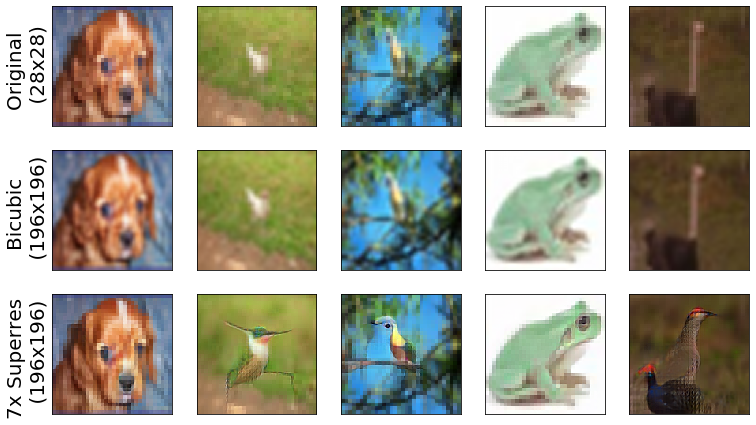

In [20]:
# Bicubic upsampling CIFAR
cifar_stack = img_cifar.numpy()
cifar_stack_us = np.zeros([10,3,196,196])
for i in range(len(cifar_stack)):
    for j in range(len(cifar_stack[i])):
        cifar_stack_us[i][j] = cv2.resize(cifar_stack[i][j],(196,196),interpolation=cv2.INTER_CUBIC)

start = 0
end = 5

show_image_row([img_cifar.cpu()[start:end,:,:,:], ch.tensor(cifar_stack_us)[start:end,:,:,:], img_cifar_sr.detach().cpu()[start:end,:,:,:]],
               ["Original \n (28x28)", "Bicubic \n (196x196)", "7x Superres \n (196x196)"],
               fontsize=20)